# PySpice_EyePoint_CurveTracer
## часть проекта по восстановлению электронной схемы характериографом
### генерация базы сигналов с разных схем для последующего обучения модели

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
from sklearn import __version__ as sk_version

import PySpice
import PySpice.Logging.Logging as Logging

from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Doc.ExampleTools import find_libraries

from PySpice.Unit import *
import sys
import os
import uuid
import random

logger = Logging.setup_logging()
PySpice.show_version()

print('sklearn version '+sk_version)


FILEBASE_ROOT = 'E:\EyePoint'
if not os.path.exists(FILEBASE_ROOT):
    os.makedirs(FILEBASE_ROOT)

print('simulation dataset on:\n'+FILEBASE_ROOT)

libraries_path = os.path.join(FILEBASE_ROOT,'spice_library')
print('spice models library on:\n'+libraries_path)
spice_library = SpiceLibrary(libraries_path)
print(spice_library['1N4148'])

Circuit_Set = set() # set of all availible curcuits 



PySpice Version 1.4.3
sklearn version 1.0.2
simulation dataset on:
E:\EyePoint
spice models library on:
E:\EyePoint\spice_library
E:\EyePoint\spice_library\diode\switching\1N4148.lib


### код CreateCVC базируется на библиотеке MySpice
https://github.com/LukyanovM/MySpice

используем эту библиотеку, ибо она максимально близко имитирует прибор

In [2]:
import math
import numpy

class CurveTracer_Settings():
    """ EyePoint hardware settings struct"""
    def __init__(self,F=10_000,V=3.3,Rcs=0,SNR=40.0,lendata=50,cycle=3):
        self.F = F
        self.V = V
        self.Rcs = Rcs
        self.SNR = SNR
        self.lendata = lendata
        self.cycle = cycle
    
    def to_numpy(self):
        arr = np.array([self.F, self.V, self.Rcs, self.SNR, self.lendata, self.cycle])
        return arr
    
    def from_numpy(self,arr):
        self.F = arr[0]
        self.V = arr[1]
        self.Rcs = arr[2]
        self.SNR = arr[3]
        self.lendata = arr[4]
        self.cycle = arr[5]
    
ct_default_settings = CurveTracer_Settings()

def plot_analysis_IV(analysis,ax=None):
    """ plot I(V) curve for analysis """
    if ax is None:
        plt.grid()
        plt.plot(analysis.input_dummy, analysis.VCurrent)
        plt.title('I(V)')
        plt.xlabel('Напряжение [В]')
        plt.ylabel('Сила тока [А]')
        return
    ax.grid()
    ax.plot(analysis.input_dummy, analysis.VCurrent)
    ax.set_title('I(V)')
    ax.set_xlabel('Напряжение [В]')
    ax.set_ylabel('Сила тока [А]')
    

def CreateCVC(circuit,ct=ct_default_settings):
    cycle = ct.cycle
    lendata = ct.lendata
    period = 1 / ct.F
    rms_voltage = ct.V / math.sqrt(2)
    # добавляем испытательный щуп в схему
    circuit.R('cs', 'input', 'input_dummy', ct.Rcs)
    circuit.AcLine('Current', circuit.gnd, 'input_dummy', rms_voltage=rms_voltage, frequency=ct.F)
    
    simulator = circuit.simulator()
    analysis = simulator.transient(step_time=period / lendata, end_time=period * cycle)
    analysis.input_dummy = analysis.input_dummy[len(analysis.input_dummy)-lendata:len(analysis.input_dummy)]
    analysis.VCurrent = analysis.VCurrent[len(analysis.VCurrent)-lendata:len(analysis.VCurrent)]
# Расчитываем шум независмо для тока и напряжения исходя из среднеквадратичных значений и одинакового SNR
    avg_V_db = 10 * numpy.log10(numpy.mean(numpy.array(analysis.input_dummy, dtype=float) ** 2))
    avg_Vnoise_db = avg_V_db - ct.SNR
    Vnoise = numpy.random.normal(0, numpy.sqrt(10 ** (avg_Vnoise_db / 10)), len(analysis.input_dummy))
    analysis.input_dummy = numpy.array(analysis.input_dummy, dtype=float) + Vnoise
    avg_I_db = 10 * numpy.log10(numpy.mean(numpy.array(analysis.VCurrent, dtype=float) ** 2))
    avg_Inoise_db = avg_I_db - ct.SNR
    Inoise = numpy.random.normal(0, numpy.sqrt(10 ** (avg_Inoise_db / 10)), len(analysis.VCurrent))
    analysis.VCurrent = numpy.array(analysis.VCurrent, dtype=float) + Inoise
    # удаляем испытательный щуп из схемы
    circuit.Rcs.detach()
    circuit.VCurrent.detach()
    return analysis


#### пример использования CreateCVC

2022-01-31 22:46:27,253 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - spinit was not found
2022-01-31 22:46:27,254 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: can't find init file.


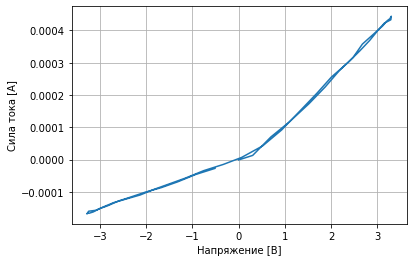

Wall time: 2.14 s


In [3]:
%%time
circuit = Circuit('RD')
circuit.include(spice_library['1N4148'])
circuit.R(1,'input',1,10@u_kOhm)
circuit.X('D1', '1N4148', 1, circuit.gnd)
circuit.R(2,'input',circuit.gnd,20@u_kOhm)

analysis = CreateCVC(circuit)
        
plt.grid()
plt.plot(analysis.input_dummy, analysis.VCurrent)
plt.xlabel('Напряжение [В]')
plt.ylabel('Сила тока [А]')
plt.show()



### как построена база?
каждой схеме соответствует папка, в которой хранятся файлы массивов симуляции c номиналами схемы и параметрами прибора,и circuit файл - информация о самой схеме

In [4]:
%%time
def save_cir_analysis(fileName,circuit_params,curve_params,analysis):
    """ save circuit nominals,curve tracer parameters, voltage and current arrays to file"""
    with open(fileName, 'wb') as f:
        np.save(f,circuit_params)
        np.save(f,curve_params)
        np.save(f,analysis.VCurrent)
        np.save(f,analysis.input_dummy)
    
def make_sure_path(path_title):
    """ create path if path not exist, return full path """
    dirName = os.path.join(FILEBASE_ROOT,path_title)
    if not os.path.exists(dirName):
        os.makedirs(dirName)
    return dirName

def save_circuit(dirName,circuit):
    """ save sample circuit on disk """
    fileName = os.path.join(dirName,circuit.title+'.cir')
    with open(fileName,'w') as f:
        f.write(str(circuit))
        

Wall time: 0 ns


In [5]:
def load_circuit_dataset(path_dataset,ct_settings=None,shuffle=True,max_files=None):
    """ load dataset from circuit folder.
    return X,y """
    fileList = [f for f in os.listdir(path_dataset) if f.endswith('.npy')]
    
    if shuffle: 
        random.shuffle(fileList)
        
    if max_files is not None:
        max_files = min(max_files,len(fileList))
        fileList=fileList[0:max_files]
    
    X_data,y_data=[],[]
    
    for fileName in tqdm(fileList): # process files
        with open(os.path.join(path_dataset,fileName), 'rb') as f:
            circuit_params = np.load(f)
            curve_params = np.load(f)
            VCurrent = np.load(f)
            input_dummy = np.load(f)
            
            if ct_settings is not None: 
                ct = CurveTracer_Settings().from_numpy(curve_params)
                F_ok = math.abs(ct_settings.F-ct.F) < 0.1
                V_ok = math.abs(ct_settings.V-ct.V) < 0.05
                if (F_ok and V_ok)==False:
                    continue
                    
                len_ok = ct_settings.lendata == ct.lendata
                cyc_ok = ct_settings.cycle == ct.cycle
                if (len_ok and cyc_ok)==False:
                    continue
                    
                #Rcs_ok = math.abs(ct_settings.Rcs-ct.Rcs) < 1
                #SNR_ok = True #math.abs(ct_settings.SNR-ct.SNR) < 1
        
        # append data to arrays
        y_data.append(circuit_params)
        X_data.append([VCurrent,input_dummy])
        
    return np.array(X_data),np.array(y_data)

## препроцессор данных для моделей -
### делает преобразование фурье, прореживание и прочие манипуляции со входными сигналами

In [6]:
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from scipy.fft import rfft

def my_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        #V_signal = x[len(x)//2:] # input voltage - not use
        I_fft = rfft(I_signal)
        x_fft = I_fft[:20] # use only first 20 points on freq domain
        x_abs = np.abs(x_fft)
        x_angle = np.angle(x_fft)
        x_real = np.real(x_fft)
        x_imag = np.imag(x_fft)
        x1 = np.hstack((x,x_abs,x_angle,x_real,x_imag))
        Xa.append(x1)
        
    return np.array(Xa)

MyCustomTransformer = FunctionTransformer(my_transform_function)

#model1 = make_pipeline(RfftTransform,StandardScaler(),RegressorChain(GradientBoostingRegressor()))


## базовый класс схем

In [7]:
import pickle
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor,RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.pipeline import make_pipeline

class BaseCircuitModel():
    """ base class for circuit models. Provide training, data preprocessing,
    prediction for nominal values """
    def __init__(self,title='baseAbstract',modelDir=None,modelName=None):
        self.title = title
        self.modelDir = os.path.join(FILEBASE_ROOT,self.title) if (modelDir is None) else modelDir  
        make_sure_path(self.modelDir)
        self.modelName = title+'.pickle' if (modelName is None) else modelName   
        self.modelFileName = os.path.join(self.modelDir,self.modelName)
        self.optimize_save_flag = False
        
        try:
            self.load_model()
        except OSError as e:
            print(e)
            print('rebuild model ...')
            self.rebuild_model()
        
    
    def load_model(self):
        with open(self.modelFileName, "rb") as f:
                self.model = pickle.load(f)
                self.rank = self.model.rank # number of circuit variative nominals
    
    def save_model(self):
        with open(self.modelFileName, "wb") as f:
                self.model.rank = self.rank
                pickle.dump(self.model, f)
        
        
    def write_dataset(self,Xvals):
        """ circuit batch simulation over params Xvals"""
        for xval in tqdm(Xvals): # walk over nominals in circuit and create I/V curves
            #print(xval)
            cir_params = np.array(xval)
            circuit = self.build_circuit(cir_params)
            analysis = CreateCVC(circuit)
            fileName = os.path.join(self.modelDir,uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,cir_params,ct_default_settings.to_numpy(),analysis)

    def load_dataset(self):
        """ load dataset from disk. Can be overwritten for feature construction"""
        X_data,y_data = load_circuit_dataset(self.modelDir)
        ADim = X_data.shape[0]
        X_data = X_data.reshape(ADim,-1)
        if self.rank==1: # fit shape 1d regression or Nd regression 
            y_data = y_data.reshape(-1)
        else:
            y_data = y_data.reshape(ADim,-1)
            
        return X_data,y_data
        
    def build_model(self,estimator=None, save_model=True, test_model=True ): 
        print('dataset for model '+self.title+' is loading, please wait..')
        
        if estimator is None:
            baseEstimator = GradientBoostingRegressor()
            if self.rank>1:
                self.model = make_pipeline(MyCustomTransformer,RegressorChain(baseEstimator))
            else:
                self.model = make_pipeline(MyCustomTransformer,baseEstimator)
        else:
            self.model = estimator
        
        X_data,y_data = self.load_dataset()  
        print('model '+self.title+' is training, please wait..')
        self.model.fit(X_data,y_data)
        self.model.rank = self.rank
        
        if save_model:
            self.save_model()
            self.load_model()
        
        if test_model:
            print('test_model() routine for '+self.title+' model:')
            self.test_model()
    
    def test_model(self):
        print('!!WARNING : test_model() routine for '+self.title+' model not implemented')
            
    def predict_from_model(self,analysis0):
        """ predict X values for circuit, best fitted to analysis0 """
        X = np.array([analysis0.VCurrent,analysis0.input_dummy]).reshape(-1)
        a = self.model.predict([X])[0]
        return a
        
    def misfit(self,analysis0, Xvals=None):
        """ calculate mse for current from circuit from Xval simulation and from analysis"""
        if Xvals is None:
            Xvals = self.predict_from_model(analysis0)
            
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit)
        
        return mean_squared_error(analysis1.VCurrent,analysis0.VCurrent)
    
    def _optimize_func(self,Xvals):      
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit)
        
        if self.optimize_save_flag:
            fileName = os.path.join(self.modelDir,'o_'+uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,Xvals,ct_default_settings.to_numpy(),analysis1)

        return mean_squared_error(analysis1.VCurrent,self._analysis0.VCurrent)

    def optimize_from_X(self,analysis0,Xvalues = None):
        if Xvalues is None:
            Xvalues = self.predict_from_model(analysis0).reshape(-1)
        self._analysis0 = analysis0 #
        
        optimize_result = minimize(self._optimize_func,Xvalues)
        
        return (optimize_result.x, optimize_result)
        
    


### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 1, rank 2

In [8]:
######################################################################

class R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('R')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
            
        circuit = Circuit('R')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(1.,100.))
        self.write_dataset(np.linspace(0.,20.))
        self.write_dataset(np.linspace(50.,500.,10))
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
            
Circuit_Set.add(R_circuit)
    
######################################################################

class C_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('C')
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            c1 = Xvals
        elif isinstance(Xvals, list):
            c1 = Xvals[0]
        else: # it is numpy array
            c1 = Xvals.item()
            
        circuit = Circuit('C')
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(0.5,100))
        self.write_dataset(np.linspace(0.001,1.5,100))
        self.build_model()
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for c in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(c))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-c)/c)
            print(str(c),str(x),str(acc),sep='\t')
    
Circuit_Set.add(C_circuit)
    
######################################################################

class L_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('L')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            l1 = Xvals
        elif isinstance(Xvals, list):
            l1 = Xvals[0]
        else: # it is numpy array
            l1 = Xvals.item()
            
        circuit = Circuit('L')
        circuit.L(1,'input',circuit.gnd,l1@u_uH)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(0.001,10))
        self.write_dataset(np.linspace(3,100))
        self.write_dataset(np.linspace(50,1000))
        self.build_model()
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for l in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 175., 398., 700.]):
            analysis0 = CreateCVC(self.build_circuit(l))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-l)/l)
            print(str(l),str(x),str(acc),sep='\t')
        
Circuit_Set.add(L_circuit)
######################################################################

class DR_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        
        circuit = Circuit('DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', circuit.gnd)
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(1,100))
        self.write_dataset(np.linspace(0,3.))
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(DR_circuit)
######################################################################

class D_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('D_R')       
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        
        circuit = Circuit('D_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(1,100))
        self.write_dataset(np.linspace(0,3.))
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(D_R_circuit)
###################################################################

class RC_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('RC')
        
    def build_circuit(self,Xvals):
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('RC')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
        
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(1e-2,10)))
        self.write_dataset(itertools.product(np.linspace(1,20),np.linspace(3,30)))
        self.write_dataset(itertools.product(np.linspace(0,4),np.linspace(1e-2,10)))
        self.build_model()
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]))
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(RC_circuit)
###################################################################

class R_C_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('R_C')
            
    def build_circuit(self,Xvals):
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('R_C')
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.C(1,2, circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(1e-2,10)))
        self.write_dataset(itertools.product(np.linspace(1,20),np.linspace(3,30)))
        self.write_dataset(itertools.product(np.linspace(0,4),np.linspace(1e-2,10)))
        self.build_model()
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]))
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(R_C_circuit)
###################################################################

class DR_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR_R')
        
    def build_circuit(self,Xvals): 
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.R(2,2,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(0,100)))   
        self.write_dataset(itertools.product(np.linspace(0,20),np.linspace(0,20)))     
        self.write_dataset(itertools.product(np.linspace(0,10),np.linspace(0,10)))   
        self.write_dataset(itertools.product(np.linspace(0,1),np.linspace(0,10)))   
        self.write_dataset(itertools.product(np.linspace(0,10),np.linspace(0,1)))   
        self.build_model()
        
    def test_model(self):
        print('real r1','real r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]))
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_R_circuit)
    
###################################################################

class DR_DR_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR_DR')
        
    def build_circuit(self,Xvals): 
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(0,100)))   
        self.write_dataset(itertools.product(np.linspace(0,20),np.linspace(0,20)))     
        self.write_dataset(itertools.product(np.linspace(0,10),np.linspace(0,10)))    
        self.build_model()
        
    def test_model(self):
        print('r1','r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]))
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_DR_circuit)

### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 3

In [9]:
###################################################################

class DR_DR_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR_DR_R')
        
    def build_circuit(self,Xvals): 
        r1,r2,r3 = Xvals[0],Xvals[1],Xvals[2]
        
        circuit = Circuit('DR_DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        circuit.R(3,'input',circuit.gnd,r3@u_kOhm)
        
        return circuit

    
    def rebuild_model(self):
        self.rank = 3
        self.write_dataset(itertools.product(np.linspace(0,100,20),np.linspace(0,100,20),np.linspace(0,100,20)))   
        self.build_model()
        
    def test_model(self):
        print('r1','r2','r3','r1?','r2?','r3?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        R3 = [1., 0.1, 10., 30., 5.]
        for r1,r2,r3 in zip(R1,R2,R3):
            analysis0 = CreateCVC(self.build_circuit([r1,r2,r3]))
            r1x,r2x,r3x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r3),str(r1x),str(r2x),str(r3x),sep='\t')
    
Circuit_Set.add(DR_DR_R_circuit)

### тестирование разных схем

In [10]:
EP = DR_DR_circuit()
EP.test_model()

EP = DR_DR_R_circuit()
EP.test_model()

r1	r2	r1?	r2?
0.1	1.0	0.6430076116176082	0.7473099999991804
2.0	0.1	2.151246105211173	0.7473099999991804
5.0	10.0	5.298501125232144	10.093049248670724
10.0	30.0	9.84063523426473	29.765181148132726
70.0	5.0	79.63734917517405	4.931053429464096
r1	r2	r3	r1?	r2?	r3?
0.1	1.0	1.0	0.31509398620007234	48.15004819886926	36.51707231011042
2.0	0.1	0.1	50.59845061473534	-1.4166929991941841	35.04148464607706
5.0	10.0	10.0	3.495802061356912	17.40764152480865	16.467837314952273
10.0	30.0	30.0	5.9705210433135925	42.52380890998555	35.430283037520695
70.0	5.0	5.0	71.00452036151654	6.436843542757028	9.960230044271492


### Класс для предсказания схемы по ВАХ

RANK1 CIRCUIT TESTING ..
success: [75.29266481] -> 26.851093952045353 circuit DR
SUCCESS:


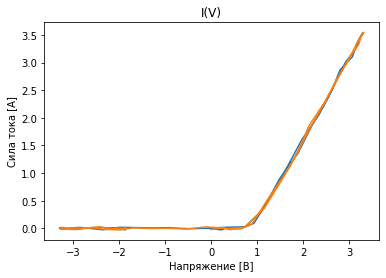

!!fail:  [24.40235094] -> [25.14451193 24.46230268] C detected like RC
FAIL:


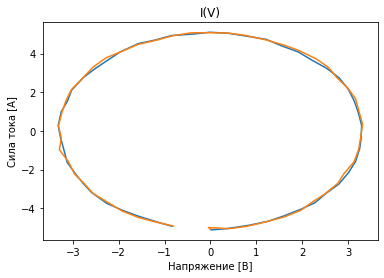

success: [91.5150827] -> 91.89515145743819 circuit C
SUCCESS:


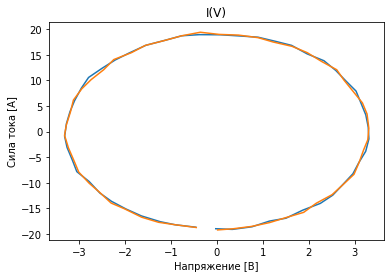

success: [24.87647692] -> 25.86765387582649 circuit D_R
SUCCESS:


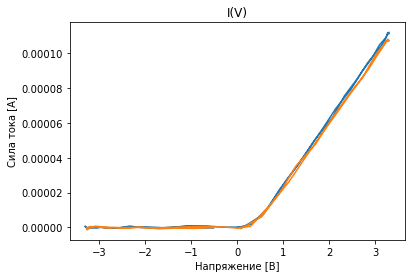

!!fail:  [12.70070922] -> [ 9.84193305 12.90192785] C detected like RC
FAIL:


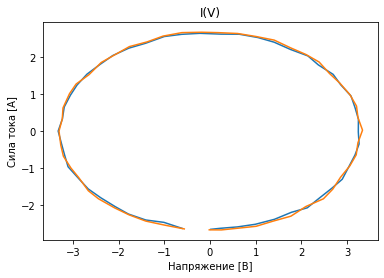

success: [4.18197259] -> 4.17779946955014 circuit R
SUCCESS:


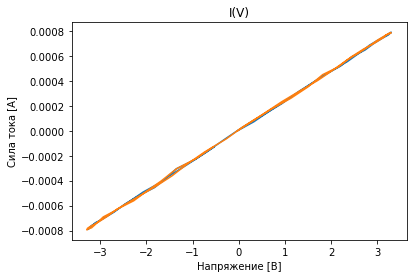

!!fail:  [55.75803408] -> [ 4.48672887 52.65457936] R detected like DR_R
FAIL:


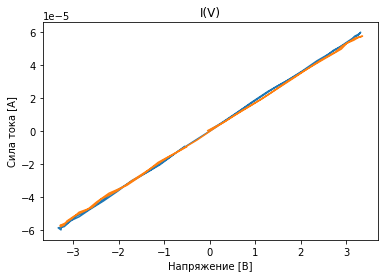

!!fail:  [71.62463281] -> [71.42185058  4.93974452] R detected like R_C
FAIL:


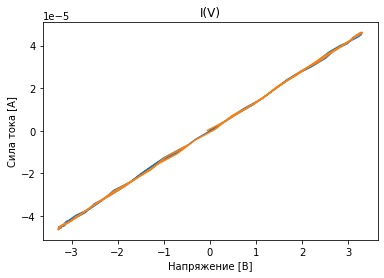

success: [92.84572206] -> 94.30275445756003 circuit L
SUCCESS:


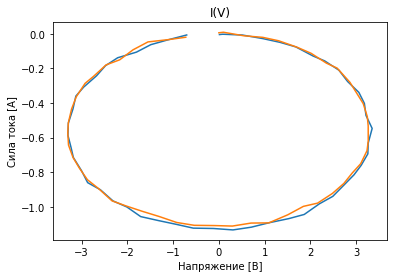

success: [43.67296365] -> 44.19982693427183 circuit C
SUCCESS:


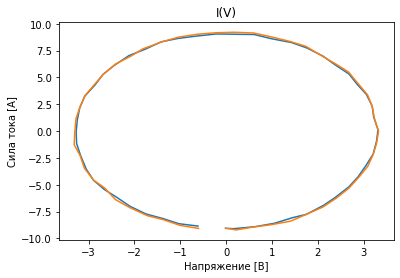

success: [86.15695695] -> 85.0279787093895 circuit R
SUCCESS:


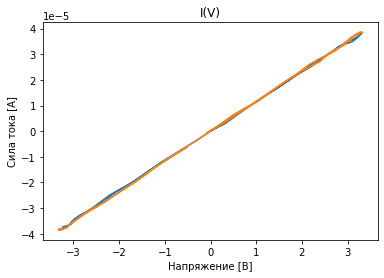

success: [0.42224482] -> 0.5422472040671481 circuit L
SUCCESS:


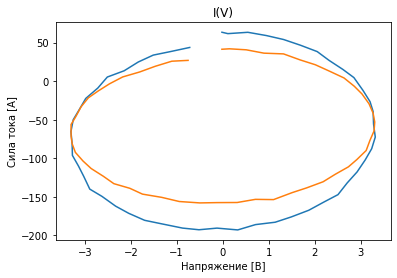

success: [57.65209221] -> 58.365857637655104 circuit C
SUCCESS:


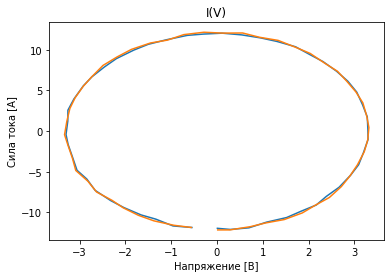

success: [39.06116231] -> 38.72032718113578 circuit L
SUCCESS:


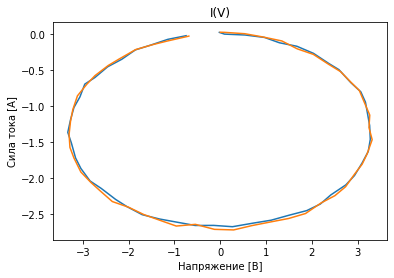

success: [83.12588106] -> 82.52560775593692 circuit D_R
success: [71.16487617] -> 29.82812656576607 circuit DR
success: [92.07253935] -> 93.56491905445363 circuit C
success: [70.25588796] -> 69.8862114789571 circuit C
success: [27.06743701] -> 26.909219366559824 circuit C
success: [27.77149106] -> 27.67557870406552 circuit C
success: [84.93163695] -> 84.07101912925756 circuit D_R
success: [36.57058536] -> 38.37966026069385 circuit DR
!!fail:  [18.90318207] -> [13.23376719 18.9678553 ] C detected like RC
FAIL:


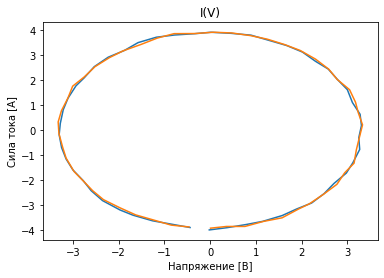

success: [57.87435913] -> 58.861780072689584 circuit C
success: [71.14264407] -> 72.85002011216804 circuit D_R
success: [89.47361915] -> 90.91159849071643 circuit C
!!fail:  [38.43010845] -> [ 5.37781355 33.23879675] R detected like DR_R
FAIL:


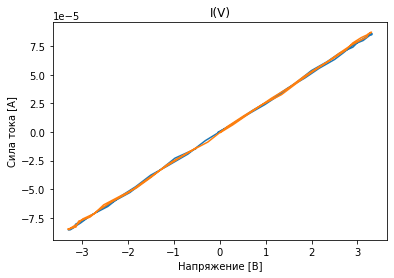

success: [74.30814902] -> 75.53945860952686 circuit C
!!fail:  [81.18953794] -> [81.62590299  5.20494357] R detected like R_C
FAIL:


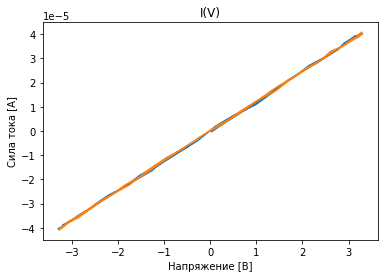

success: [76.54364955] -> 77.52273245138268 circuit L
!!fail:  [49.1468503] -> [ 4.75357451 44.45830905] R detected like DR_R
FAIL:


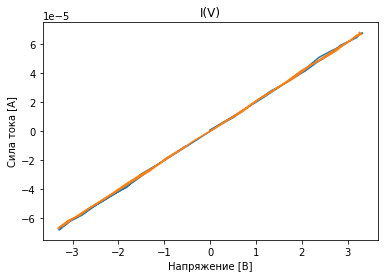

success: [3.33344213] -> 3.4675382749841615 circuit D_R
success: [15.64750241] -> 14.931549570165979 circuit D_R
success: [73.05703484] -> 23.428623459161646 circuit DR
success: [64.99804374] -> 63.22488278503835 circuit D_R
success: [49.05387127] -> 33.291692910250696 circuit DR
success: [56.24130406] -> 25.473149253381607 circuit DR
success: [29.63411024] -> 29.604913771594184 circuit D_R
success: [88.09539028] -> 37.12282517975123 circuit DR
success: [66.49318218] -> 22.52878659048836 circuit DR
success: [1.14951762] -> 1.107627591893298 circuit D_R
success: [81.57183157] -> 82.57515581871584 circuit L
success: [99.26299624] -> 97.29906452225113 circuit C
success: [20.15922982] -> 20.771754938269424 circuit D_R
success: [77.77797889] -> 77.49348506245035 circuit C
success: [7.3729033] -> 7.297930592988258 circuit R
success: [10.6791796] -> 11.112765470979367 circuit D_R
success: [93.56814985] -> 93.2641225432723 circuit C
success: [87.27477298] -> 86.75592660914896 circuit L
success

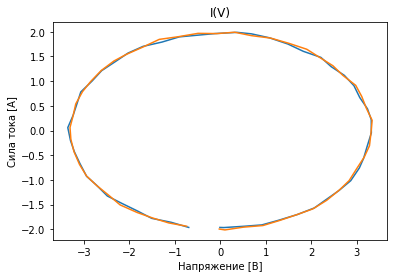

success: [28.12832096] -> 27.691669383694364 circuit R
!!fail:  [66.53213861] -> [ 4.8499756  61.93209614] R detected like DR_R
FAIL:


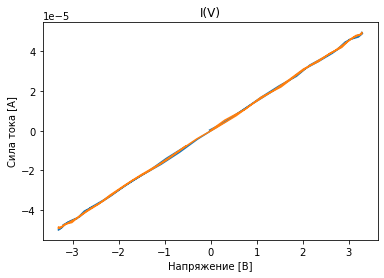

success: [60.81043726] -> 59.34968263339963 circuit L
success: [99.56718622] -> 98.99580549767032 circuit L
success: [38.77726124] -> 37.89533633075208 circuit L
success: [43.86083149] -> 44.41998305127611 circuit D_R
success: [71.88367082] -> 70.84026737800446 circuit C
success: [52.23712726] -> 52.07550443132001 circuit L
success: [47.74796002] -> 47.11683886061343 circuit R
success: [90.73556076] -> 90.85504369108348 circuit C
success: [76.67428508] -> 75.71438042454838 circuit C
success: [68.3742882] -> 68.66269200140485 circuit C
!!fail:  [4.48291814] -> [ 4.48807255 15.28796486] R detected like R_C
FAIL:


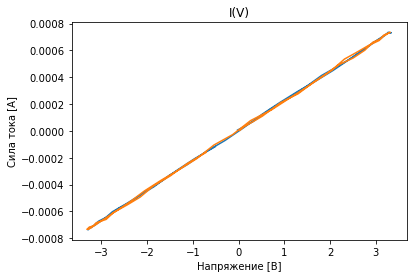

!!fail:  [16.79422583] -> [12.56718906 16.77219064] C detected like RC
FAIL:


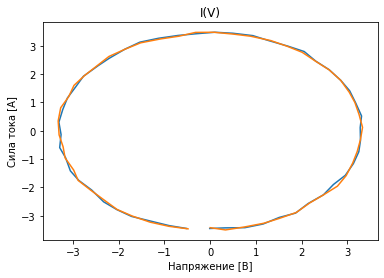

success: [57.95530941] -> 58.67163012620555 circuit D_R
success: [99.96053135] -> 99.12502634015566 circuit L
success: [45.02420794] -> 29.472184745163286 circuit DR
success: [28.16421308] -> 28.267603620377233 circuit C
success: [31.84279005] -> 32.023007685741014 circuit L
success: [17.37612345] -> 1.2575823312530037 circuit DR
!!fail:  [3.84324264] -> [97.14030547  3.98900755] D_R detected like DR_R
FAIL:


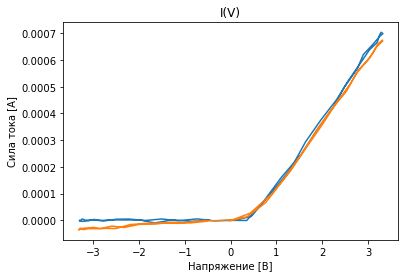

!!fail:  [58.74472227] -> [ 4.08797319 55.23638543] R detected like DR_R
FAIL:


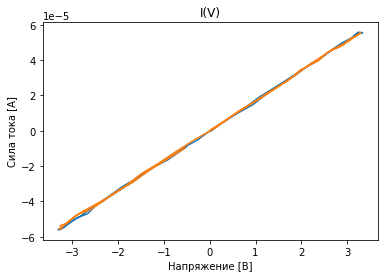

success: [9.94981238] -> 6.649456777226847 circuit DR
success: [90.75541842] -> 90.9675631081698 circuit C
success: [3.35022627] -> 21.871375638418026 circuit DR
success: [28.07707744] -> 58.38466175065471 circuit DR
success: [18.32197528] -> 18.58397395521933 circuit D_R
success: [71.57789148] -> 40.89592085648186 circuit DR
success: [48.12048524] -> 31.877628324656463 circuit DR
!!fail:  [6.4084959] -> [0.27627773 5.99251904] R detected like DR_R
FAIL:


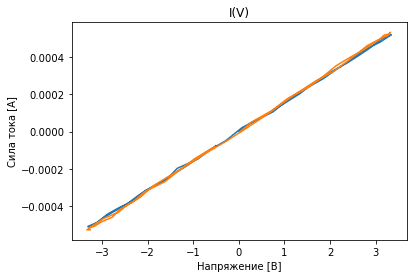

success: [91.65584476] -> 91.24487002842675 circuit R
!!fail:  [73.5079836] -> [73.46516228  4.6689993 ] R detected like R_C
FAIL:


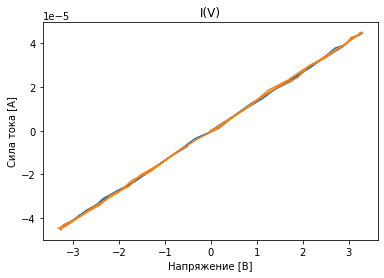

!!fail:  [26.35351415] -> [ 4.3637829  22.65381457] R detected like DR_R
FAIL:


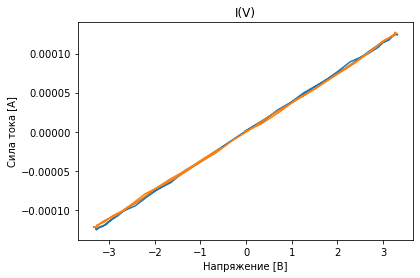

success: [35.49838156] -> 16.385445913679373 circuit DR
success: [64.20771234] -> 65.81041400196523 circuit L
success: [15.60153577] -> 15.074829471944167 circuit L
success: [11.85001611] -> 11.705581748273108 circuit R
success: [89.43101151] -> 91.65697165078684 circuit D_R
success: [83.46089244] -> 84.94773969349431 circuit D_R
success: [46.58912893] -> 48.351817262233254 circuit C
success: [34.43142824] -> 33.15054155245217 circuit C
success: [80.44817894] -> 81.26820436113277 circuit C
success: [79.3981287] -> 40.47283713746627 circuit DR
success: [29.06508461] -> 48.49541511995751 circuit DR
success: [83.40197892] -> 22.83095965168552 circuit DR
success: [32.73714285] -> 33.48432735492637 circuit D_R
success: [45.72034926] -> 44.40773143978225 circuit L
success: [99.24221232] -> 98.47331323592377 circuit C
success: [48.76353564] -> 47.930548242484534 circuit C

SUCCESS: 83, FAIL: 17 of 100 tests
RANK2 CIRCUIT TESTING ..
success: [95.52463402  2.61061924] -> [95.90972771  5.8942014

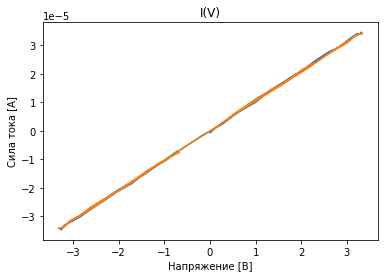

success: [70.01180892 37.91035732] -> [70.2533114  37.61772241] circuit DR_DR
SUCCESS:


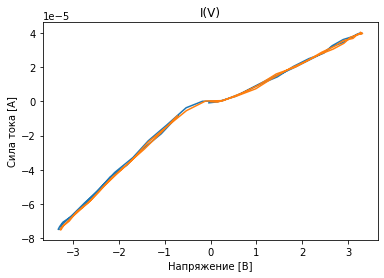

success: [43.52225549 61.00621217] -> [34.14248096 60.79603274] circuit DR_R
SUCCESS:


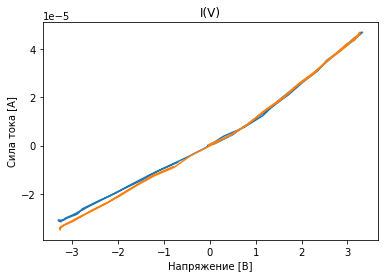

success: [25.87594844 54.12773014] -> [26.51205511  5.00064114] circuit R_C
SUCCESS:


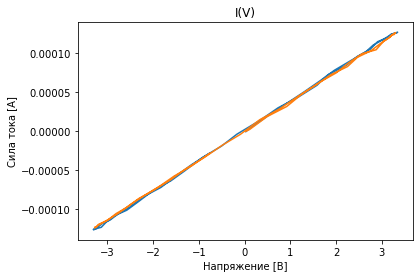

success: [38.80479499 44.04371736] -> [38.66391393  4.96928924] circuit R_C
SUCCESS:


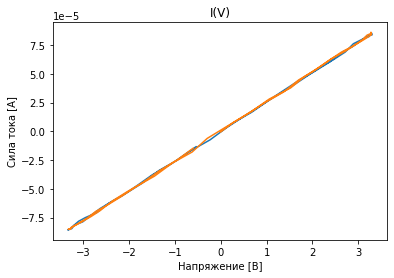

!!fail:  [17.73338157 42.97325894] -> 43.85852637077164 RC detected like C
FAIL:


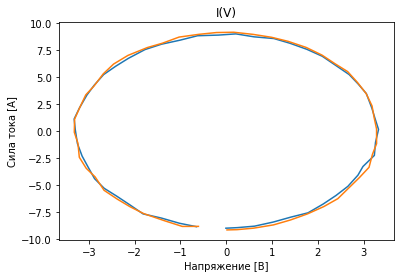

!!fail:  [79.50621052 56.44067778] -> 59.62833635175312 RC detected like C
FAIL:


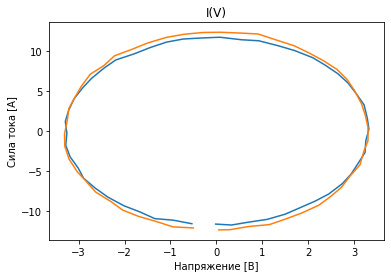

success: [51.85628887 15.13946885] -> [10.93155948 15.11132646] circuit RC
SUCCESS:


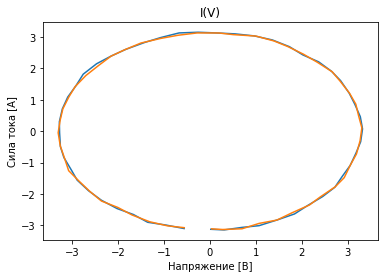

success: [96.25727897  3.19631709] -> [95.90912264  5.24793668] circuit R_C
SUCCESS:


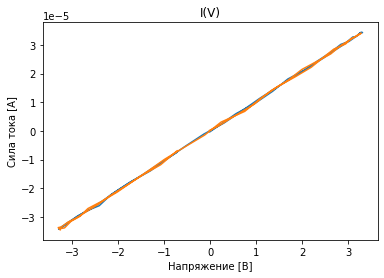

!!fail:  [55.199118   57.81873545] -> 59.65667529772473 RC detected like C
FAIL:


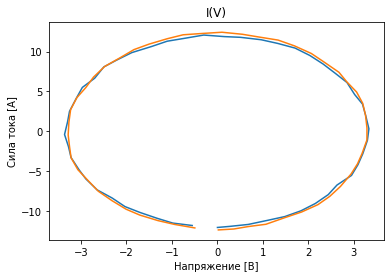

success: [43.96965554  5.72328211] -> [43.66722406  5.88579982] circuit DR_DR
SUCCESS:


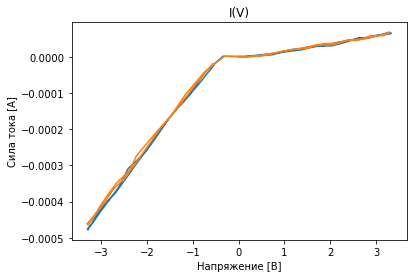

!!fail:  [83.25834994 35.30217117] -> 32.76376281728265 RC detected like C
FAIL:


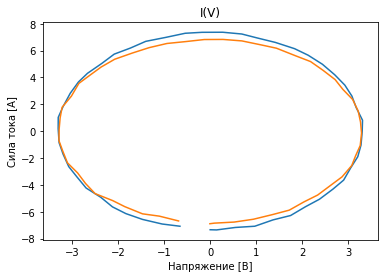

success: [ 7.60876639 17.23949158] -> [ 7.95324382 17.48254235] circuit DR_DR
SUCCESS:


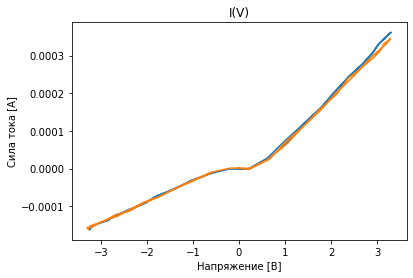

success: [86.56711513 16.8935714 ] -> [85.69384658  4.76250185] circuit R_C
SUCCESS:


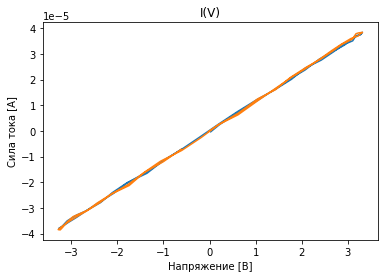

success: [49.55586892 86.62333728] -> [49.02104066  5.34935183] circuit R_C
success: [11.46726666 17.95525996] -> [11.74698435 17.88036115] circuit RC
success: [97.20749021 74.88598244] -> [92.30499564 75.2525693 ] circuit DR_R
success: [94.31371257 63.51670615] -> [96.51577345 64.50115007] circuit DR_DR
!!fail:  [35.63520759 97.57607165] -> 96.42026867177967 RC detected like C
FAIL:


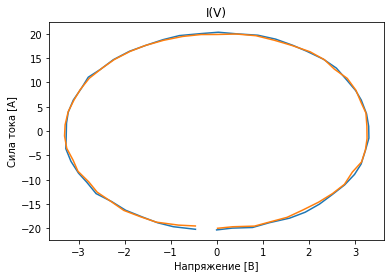

success: [12.11238026 27.91333991] -> [12.03651861 14.27147736] circuit R_C
success: [51.18425157 67.09310443] -> [56.53744441 65.51239519] circuit DR_R
success: [44.07243071 56.5164768 ] -> [44.36516261  5.37142372] circuit R_C
success: [97.71776602 70.02695179] -> [96.51577345 68.37832694] circuit DR_DR
success: [92.40051264 25.35773332] -> [88.76447017 26.41662904] circuit DR_R
success: [ 7.39471438 19.19038958] -> [ 7.14973484 14.84225732] circuit R_C
success: [ 3.45838934 19.67014028] -> [25.84884977 19.51854765] circuit RC
success: [88.73143283  9.51220753] -> [87.76641333  5.06876379] circuit R_C
success: [70.93606219 74.00947937] -> [71.23984274 73.97632187] circuit DR_R
success: [32.45091259 31.07065705] -> [32.66369597  5.23772954] circuit R_C
!!fail:  [21.57555986 13.92679732] -> 14.160160991353646 RC detected like C
FAIL:


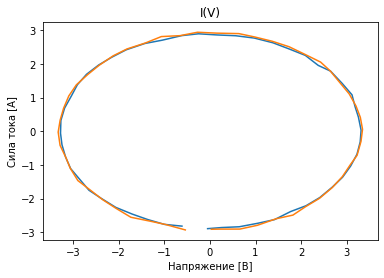

success: [75.61135739 81.65119778] -> [75.22884391 82.08502498] circuit DR_DR
success: [27.32458112 89.68472222] -> [26.88860866 94.00285137] circuit DR_DR
!!fail:  [72.30445494 57.01167247] -> 57.24993080415957 RC detected like C
FAIL:


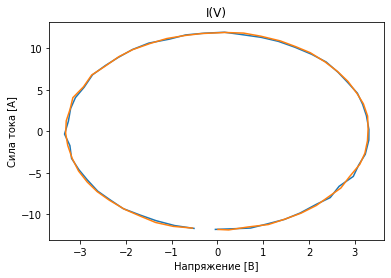

success: [24.22618408 77.3578612 ] -> [24.78162944 75.4545023 ] circuit DR_DR
success: [80.85196302  6.26165998] -> [81.62928206  5.03155932] circuit R_C
success: [64.51038555 97.29031502] -> [64.59524525 94.00285137] circuit DR_DR
success: [64.2641548  62.32913454] -> [62.50315062 63.09029197] circuit DR_DR
success: [ 5.26874932 81.19272796] -> [ 5.38281886 78.41844822] circuit DR_DR
success: [21.85856248 43.43616717] -> [22.44602455  5.98628046] circuit R_C
success: [79.83571479 64.53425584] -> [79.60597947  4.91441949] circuit R_C
success: [66.49812635 29.42969965] -> [66.03078344 29.11142102] circuit DR_DR
!!fail:  [33.86336099  4.97038462] -> [ 5.35198652 29.091551  ] R_C detected like DR_R
FAIL:


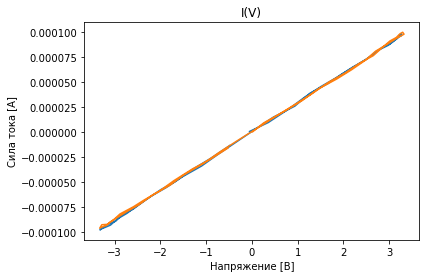

success: [ 5.95205522 61.94067258] -> [ 6.20343363 63.68490651] circuit DR_DR
!!fail:  [37.5203687  59.12875588] -> 60.491252158169395 RC detected like C
FAIL:


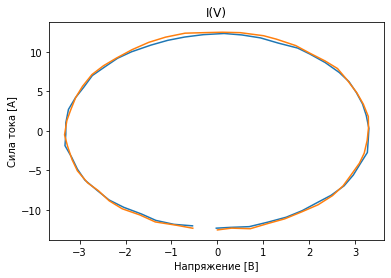

success: [70.6889031  54.95679908] -> [69.88706146 55.14669783] circuit DR_R
success: [48.50440996 96.02358698] -> [48.84302108  5.28596345] circuit R_C
success: [63.95339037 73.21621862] -> [69.88523459 72.99542567] circuit DR_R
success: [72.37675092 98.76690837] -> [73.21917098 97.50720442] circuit DR_DR
!!fail:  [59.88777843 32.43558941] -> 32.89840408397886 RC detected like C
FAIL:


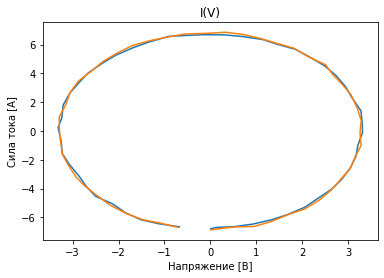

success: [28.4259156 30.7998459] -> [30.19233976 30.37419768] circuit DR_R
success: [59.26647459  9.7466795 ] -> [25.59398671  9.82669256] circuit RC
success: [92.12765308 10.4773677 ] -> [91.82940546  4.29819527] circuit R_C
!!fail:  [ 3.12694214 66.4586416 ] -> 67.62398280544365 RC detected like C
FAIL:


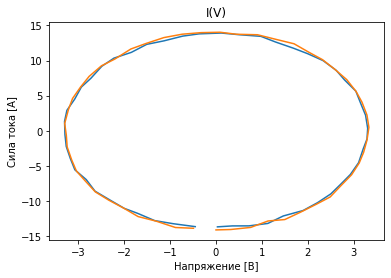

success: [47.83932591 68.73761675] -> [48.01365611  5.23697113] circuit R_C
!!fail:  [34.73730149 97.73701914] -> 96.75444751712259 RC detected like C
FAIL:


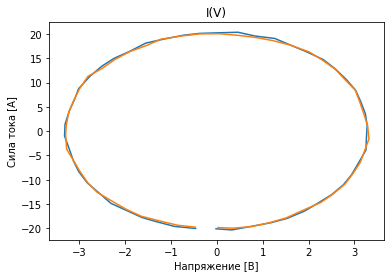

success: [92.88362822 56.83281254] -> [92.20497991 55.80134998] circuit DR_R
success: [46.73380734  8.88700108] -> [22.29354354  8.89202732] circuit RC
success: [24.53911164 20.77648523] -> [24.994041   20.28733002] circuit DR_DR
success: [89.67213539 18.34175895] -> [89.79019387  5.39501061] circuit R_C
success: [23.71743616 85.89059058] -> [24.48278725  5.81269769] circuit R_C
success: [57.19374934 11.42040529] -> [57.14223029  5.81494461] circuit R_C
success: [92.20098063 83.63175795] -> [91.3063605  84.38061781] circuit DR_R
!!fail:  [62.62198954 97.13560555] -> 95.6826108235709 RC detected like C
FAIL:


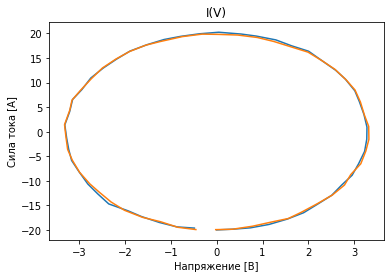

success: [15.38896293  3.52641229] -> [17.2325391   3.51057244] circuit RC
success: [55.22456955 57.99514618] -> [55.10163427  4.77258425] circuit R_C
!!fail:  [38.1610988  74.66690735] -> [ 4.1804326  33.71553636] R_C detected like DR_R
FAIL:


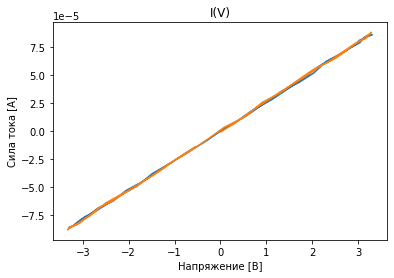

success: [99.20990066 56.85431393] -> [92.20497991 57.08556639] circuit DR_R
success: [41.140528   8.0397117] -> [26.77276666  8.18765513] circuit RC
success: [49.37174019 12.17069838] -> [49.22089063  5.42620942] circuit R_C
!!fail:  [85.84840689 86.15232023] -> 83.94610323385227 RC detected like C
FAIL:


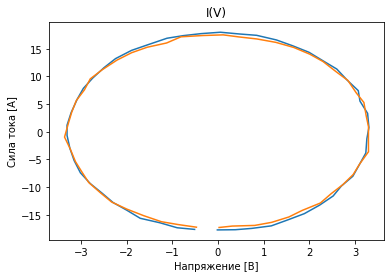

success: [47.26960147 66.59977331] -> [46.52149894 67.90264863] circuit DR_DR
success: [55.33394975 69.92281874] -> [59.93121241 69.49177673] circuit DR_R
success: [63.18263469  3.55744745] -> [15.45765468  3.51242136] circuit RC
success: [40.16612665 90.34228332] -> [40.96385436  5.15348239] circuit R_C
success: [48.79589092 26.59650868] -> [44.46137738 26.45569364] circuit DR_R
!!fail:  [65.98196144 91.00612628] -> 92.77966449370422 RC detected like C
FAIL:


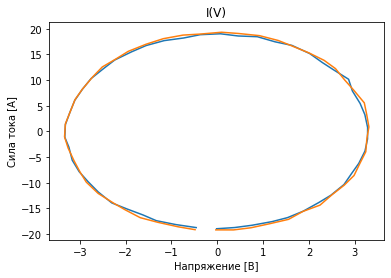

success: [90.56203158 13.40142217] -> [88.57783502 13.51410569] circuit DR_R
success: [44.86195652 74.4766563 ] -> [53.78341461 74.09050005] circuit DR_R
!!fail:  [ 7.68657296 91.72454709] -> 92.157078907392 RC detected like C
FAIL:


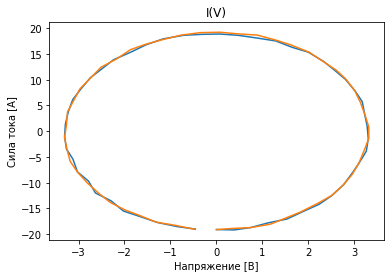

success: [25.18626127  1.67310337] -> [22.87992744  1.65051101] circuit RC
success: [ 9.19677113 40.14335627] -> [ 9.08816357 13.38629087] circuit R_C
success: [43.2227613  51.89807798] -> [48.1773139 51.9889667] circuit DR_R
success: [37.97890768  6.09788217] -> [22.96704669  6.07427791] circuit RC
!!fail:  [15.46593835 31.70697836] -> 31.496101178672404 RC detected like C
FAIL:


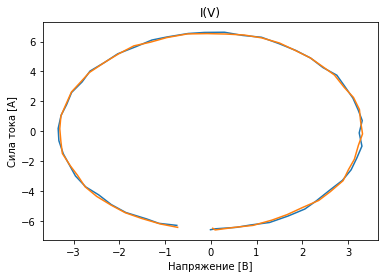

success: [64.70656203 63.09843418] -> [65.22587927  5.13894699] circuit R_C
success: [60.06782414 11.81631784] -> [61.39483117 11.7737427 ] circuit DR_R
success: [23.2707242  63.69542269] -> [19.46497564 63.19897227] circuit DR_R
success: [52.15828681 30.55413172] -> [57.67617675 30.41631821] circuit DR_R
success: [87.29787244 41.9019387 ] -> [87.76641333  4.67012902] circuit R_C
!!fail:  [37.23977603 91.75352662] -> 92.79861989015676 RC detected like C
FAIL:


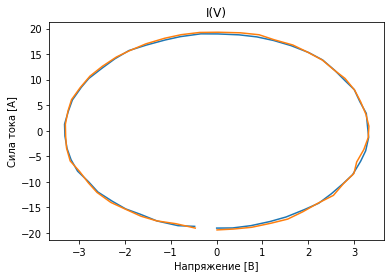

success: [85.6210002  15.76507834] -> [83.30357382 16.17489257] circuit DR_R
success: [47.31803558 90.02002137] -> [47.81771731 88.83975953] circuit DR_R
success: [ 7.19845657 89.2737292 ] -> [ 7.14856778 12.69965739] circuit R_C
success: [52.21719296 65.36220171] -> [52.45080477 65.35847843] circuit DR_DR
success: [14.51144565 79.55542756] -> [13.49400696 79.03457095] circuit DR_R
success: [33.49334456 85.97716783] -> [33.78629107 86.48274911] circuit DR_DR
success: [68.79552508 19.87923888] -> [69.40321484  5.39109393] circuit R_C
success: [55.01568478 47.33489415] -> [62.22148309 47.02910788] circuit DR_R
success: [17.17869619 14.90880749] -> [17.34847887 14.78711529] circuit R_C
success: [18.19601866 73.58559007] -> [18.12372272 16.6463863 ] circuit R_C

SUCCESS: 81, FAIL: 19 of 100 tests
RANK3 CIRCUIT TESTING ..
!!fail:  [77.64556529 18.6953201   1.26949727] -> [1.16940269 1.49439726] DR_DR_R detected like R_C
FAIL:


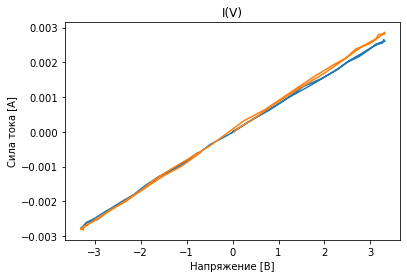

!!fail:  [ 1.08991893 80.40398407 29.62783616] -> 1.0732931930559986 DR_DR_R detected like D_R
FAIL:


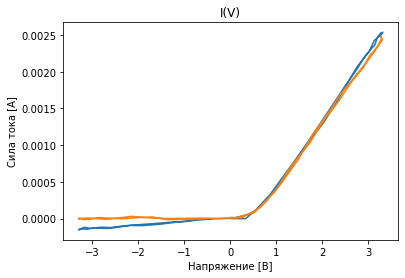

!!fail:  [28.56257278 14.89864252  6.73531271] -> [0.35724953 4.90115917] DR_DR_R detected like DR_R
FAIL:


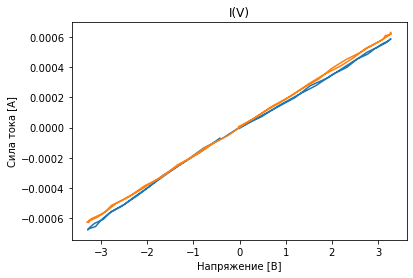

success: [33.30143633 93.34955042 93.41631109] -> [37.55828919 93.77182758 90.20359687] circuit DR_DR_R
SUCCESS:


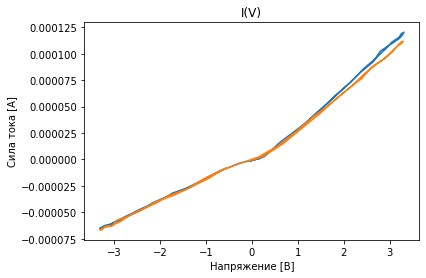

success: [29.32675695 80.99754317 85.10097681] -> [31.1309239  84.23463266 80.20876592] circuit DR_DR_R
SUCCESS:


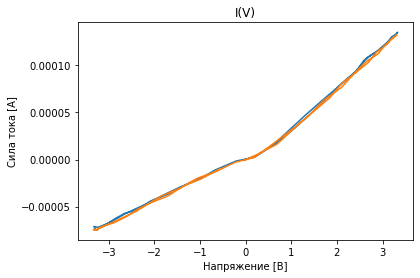

!!fail:  [80.24207925 95.73576755 12.94294056] -> [1.7488223  9.41464127] DR_DR_R detected like DR_R
FAIL:


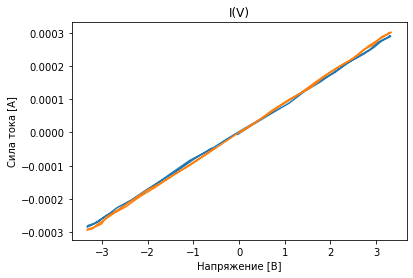

success: [63.16753855 63.07395663 39.07925928] -> [62.63389524 56.02287672 38.56367666] circuit DR_DR_R
SUCCESS:


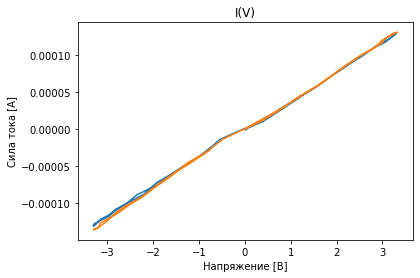

!!fail:  [16.3945898  22.64215979 93.0538575 ] -> [13.72934993 16.9592415 ] DR_DR_R detected like DR_DR
FAIL:


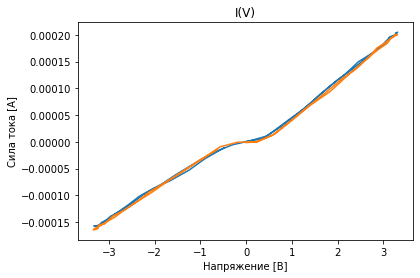

success: [35.44384983 43.32172785 10.35981872] -> [36.37870485 47.54547363 10.39990309] circuit DR_DR_R
SUCCESS:


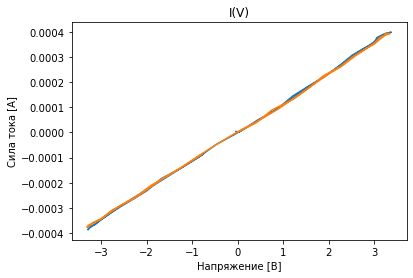

!!fail:  [32.61280369 27.41066718 46.54527029] -> [17.95511761 15.31967751] DR_DR_R detected like DR_DR
FAIL:


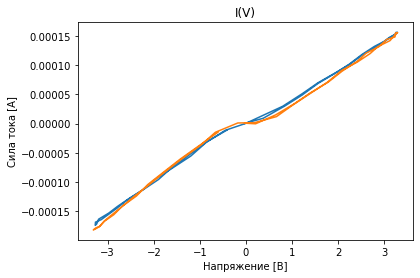

!!fail:  [13.09743851 20.84015243 25.89889664] -> [ 8.0435948 10.1237221] DR_DR_R detected like DR_DR
FAIL:


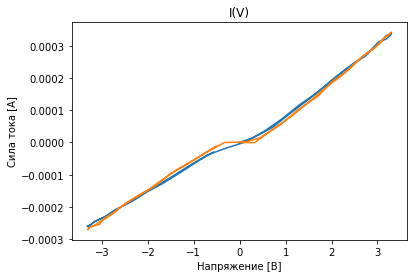

!!fail:  [ 7.88595751 37.18020994 52.97185324] -> [ 6.48806949 19.67109488] DR_DR_R detected like DR_DR
FAIL:


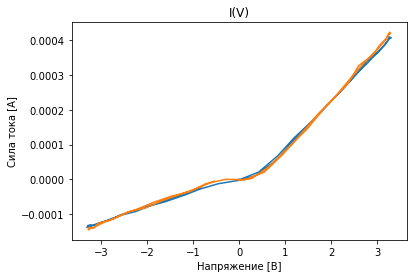

success: [ 5.14844322 72.32294716 56.23740605] -> [ 5.28965135 75.34731447 59.58732632] circuit DR_DR_R
SUCCESS:


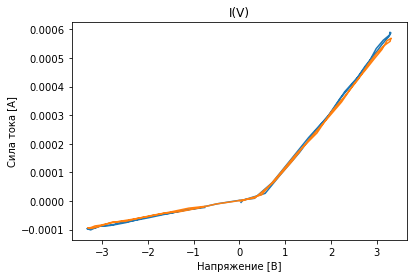

success: [34.3308798  45.89034949 84.6575709 ] -> [33.93379566 47.36748165 79.68373784] circuit DR_DR_R
SUCCESS:


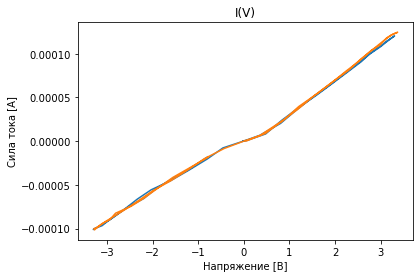

success: [37.73204966 78.94867089 54.80784939] -> [36.17559507 81.43084922 57.75310174] circuit DR_DR_R
SUCCESS:


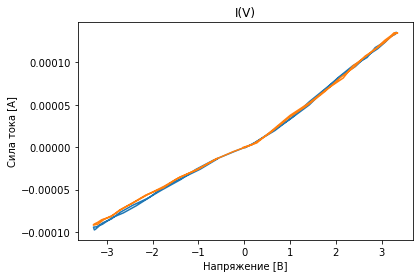

success: [97.1350993  37.19368254 18.33958845] -> [87.62106639 36.82493022 18.30930723] circuit DR_DR_R
SUCCESS:


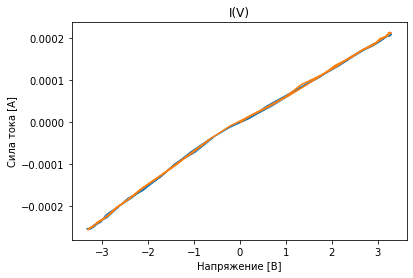

success: [41.88039732 39.96792456 95.08176242] -> [42.66729582 44.83430367 76.01620909] circuit DR_DR_R
SUCCESS:


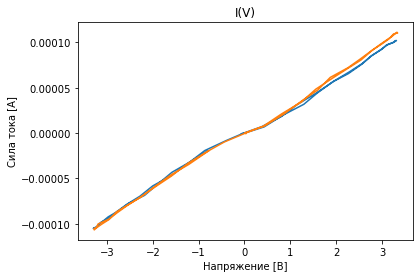

!!fail:  [26.10979777 61.0163849  35.09850815] -> [13.64121197 19.4453931 ] DR_DR_R detected like DR_DR
FAIL:


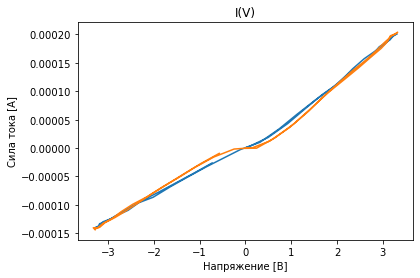

success: [ 4.99158886 77.01456881 29.62525383] -> [ 5.0105464  73.60388664 31.73594428] circuit DR_DR_R
SUCCESS:


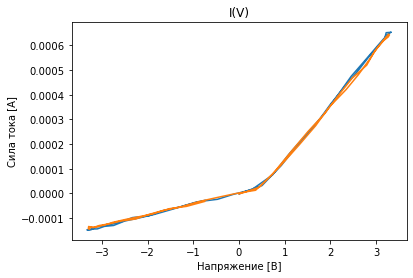

success: [50.12264528 21.09200833 30.94408433] -> [45.84666364 21.16545661 36.80174852] circuit DR_DR_R
success: [57.93553628 61.48972498 52.97863518] -> [55.10144831 57.99106596 61.63374002] circuit DR_DR_R
success: [37.93547815 75.3650094  78.86225783] -> [37.56125437 79.82829831 75.97479967] circuit DR_DR_R
!!fail:  [ 3.03538544  4.65514561 49.55634808] -> [2.98233991 4.24379246] DR_DR_R detected like DR_DR
FAIL:


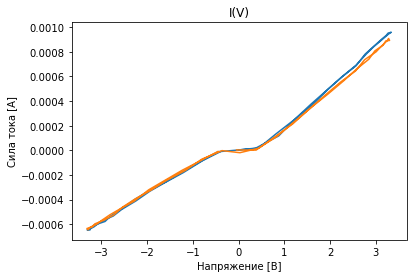

success: [31.98351657 28.17712927 91.98404376] -> [49.18927743 37.75124148 64.92374506] circuit DR_DR_R
!!fail:  [61.61873678 32.18444531 21.19835222] -> [13.64121197 10.73098235] DR_DR_R detected like DR_DR
FAIL:


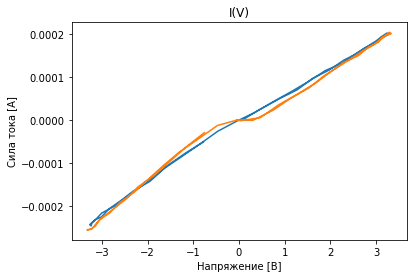

success: [60.28549967 26.53039342 62.72174475] -> [66.28024527 23.42825394 56.44273468] circuit DR_DR_R
!!fail:  [34.53374667 51.01182143 96.33649881] -> [22.33500093 30.2135045 ] DR_DR_R detected like DR_DR
FAIL:


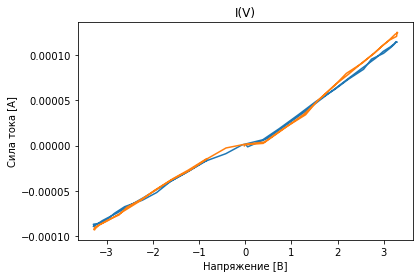

success: [29.67523013 24.27374928 73.10420981] -> [36.42208436 25.12636268 62.81415903] circuit DR_DR_R
!!fail:  [47.88394086 41.02130712 32.42228029] -> [20.40988792  3.19191528] DR_DR_R detected like R_C
FAIL:


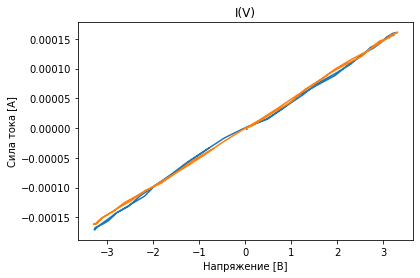

success: [30.51347035 85.72415121 76.34884012] -> [31.97639147 91.01842213 75.7627511 ] circuit DR_DR_R
!!fail:  [ 2.55029283 94.48039839 26.32206824] -> [ 2.29880561 16.43040221] DR_DR_R detected like DR_DR
FAIL:


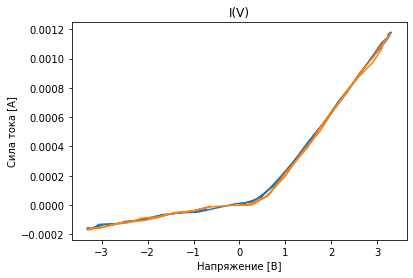

!!fail:  [42.15497039 20.04150836 82.86245787] -> [26.88860866 15.31967751] DR_DR_R detected like DR_DR
FAIL:


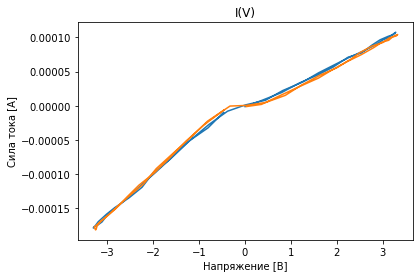

!!fail:  [26.59494735 69.87387321 32.40012619] -> [13.64121197 19.489717  ] DR_DR_R detected like DR_DR
FAIL:


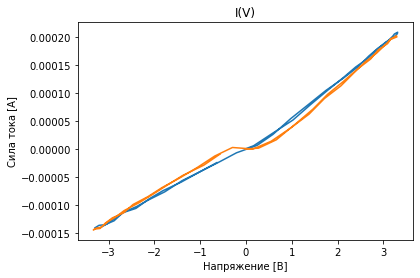

!!fail:  [97.54535001  6.62853915 22.23112041] -> [15.35272589  4.93105343] DR_DR_R detected like DR_DR
FAIL:


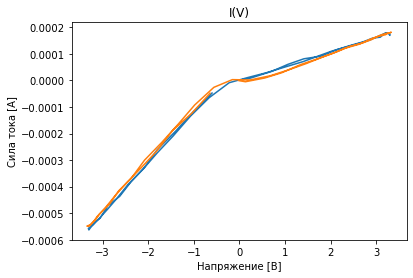

success: [22.84564861 63.46937844 98.78825273] -> [23.72696884 68.62520492 83.71003687] circuit DR_DR_R
success: [68.68592129 41.25420964 71.30593568] -> [75.27103684 38.75668842 73.85301719] circuit DR_DR_R
!!fail:  [22.78346193 62.89945007 21.58004313] -> [ 9.57737704 13.04331578] DR_DR_R detected like DR_DR
FAIL:


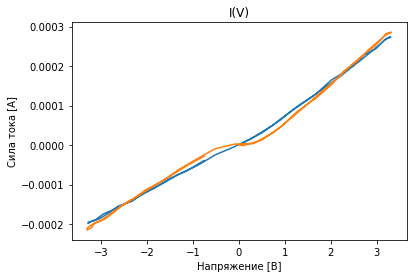

!!fail:  [98.11307908  1.80005136 16.73096041] -> [12.28647078  1.51714919] DR_DR_R detected like DR_DR
FAIL:


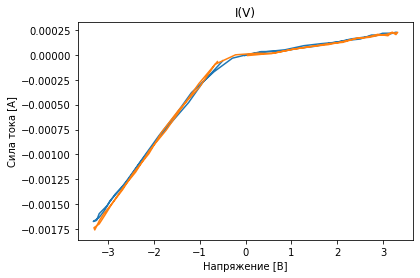

!!fail:  [16.84940718  7.45122397 58.99957195] -> [12.38036383  6.29078103] DR_DR_R detected like DR_DR
FAIL:


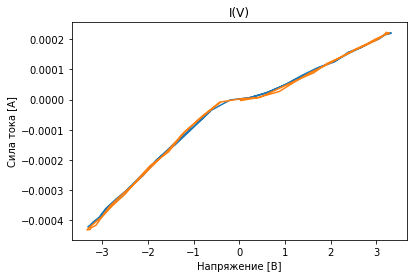

!!fail:  [33.10609334  3.4951155  87.33667268] -> [21.63392537  3.39005916] DR_DR_R detected like DR_DR
FAIL:


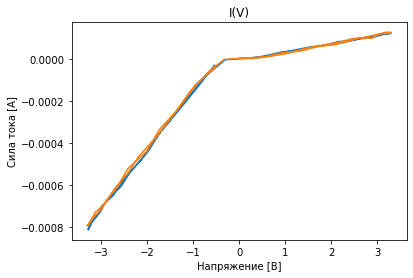

success: [90.08696258 41.93419827 85.47544663] -> [92.46611252 47.07347173 81.81337424] circuit DR_DR_R
success: [31.85620982 91.1443269  33.63922818] -> [31.00902547 88.81071719 36.47980724] circuit DR_DR_R
!!fail:  [86.06792185 15.4324144  82.44589097] -> [38.41574499 12.13323916] DR_DR_R detected like DR_DR
FAIL:


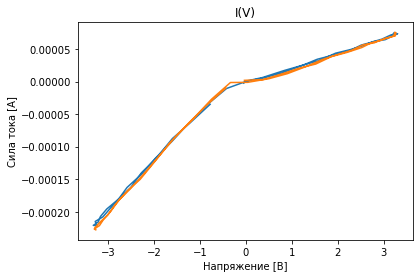

success: [52.00323453 16.71288612 50.84370511] -> [54.45734868 15.68502545 62.54405437] circuit DR_DR_R
!!fail:  [91.85850964 93.767746   83.68259774] -> [47.34963682  4.90464726] DR_DR_R detected like R_C
FAIL:


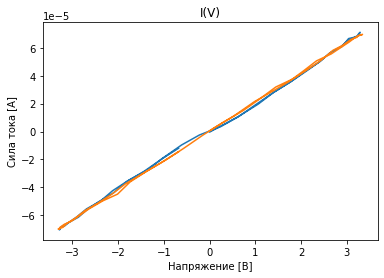

!!fail:  [ 4.54448172 18.04009583 48.59197303] -> [11.72028094  3.94323443] DR_DR_R detected like DR_R
FAIL:


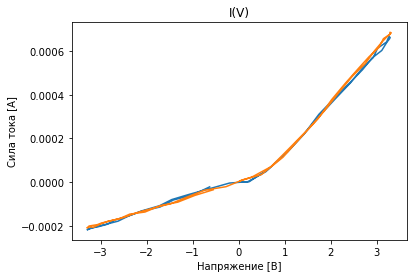

success: [82.32210667 46.35973972 72.27972287] -> [87.55543766 42.91622036 74.00552583] circuit DR_DR_R
success: [15.31615035 69.83214905 43.13989091] -> [15.89135871 66.69092562 46.87270828] circuit DR_DR_R
success: [86.91472317 76.85178004 26.05667425] -> [87.68632136 75.5361994  26.94071166] circuit DR_DR_R
success: [90.14668022 50.63975793 68.10257073] -> [91.35569635 54.24953428 67.57643318] circuit DR_DR_R
success: [42.57565627 37.43480688 63.72368098] -> [49.18927743 41.55728606 60.75616859] circuit DR_DR_R
!!fail:  [67.35277617 20.6333841  81.87426809] -> [32.83741966 16.0863335 ] DR_DR_R detected like DR_DR
FAIL:


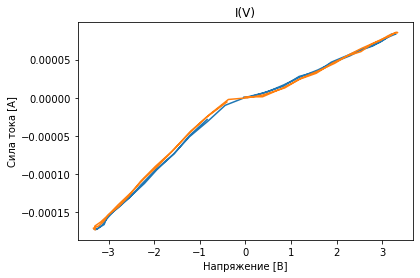

!!fail:  [73.56670649 28.84592658 16.16746109] -> [10.97514917  8.59199346] DR_DR_R detected like DR_DR
FAIL:


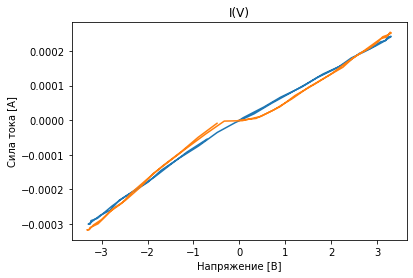

success: [41.61444092 62.30550524 65.95894614] -> [44.62659242 68.2321214  71.32281252] circuit DR_DR_R
!!fail:  [82.76425556  3.07437585 22.88168696] -> [15.25578959  2.61481073] DR_DR_R detected like DR_DR
FAIL:


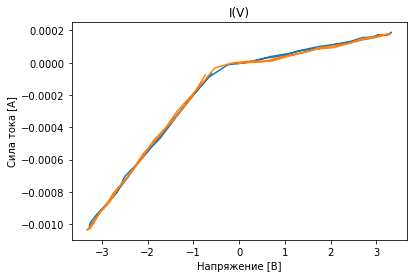

success: [15.87037472 94.20322865 73.29273879] -> [16.39194382 88.32086436 81.50437333] circuit DR_DR_R
!!fail:  [12.74544875 32.38216246 21.82196251] -> [ 6.48806949 12.00909464] DR_DR_R detected like DR_DR
FAIL:


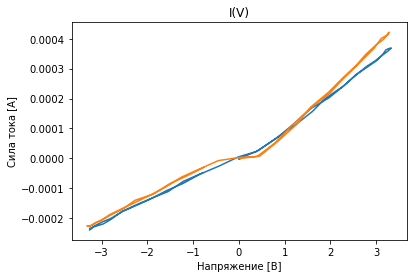

success: [15.71538403 85.9350432  54.30461542] -> [15.76250622 83.85234535 55.06908273] circuit DR_DR_R
!!fail:  [56.50810327 77.11516289 18.12886441] -> [ 2.3656552  12.48979852] DR_DR_R detected like DR_R
FAIL:


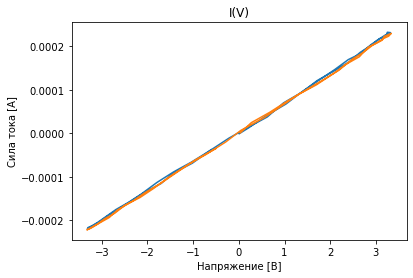

success: [44.56509498 59.96737157 88.74739343] -> [45.36290173 64.33925708 79.44309737] circuit DR_DR_R
success: [84.77485742 87.9400345  62.28740534] -> [87.40329563 83.11393682 65.10768653] circuit DR_DR_R
!!fail:  [12.03625597 14.92038687 24.29381061] -> [7.05011564 8.49033603] DR_DR_R detected like DR_DR
FAIL:


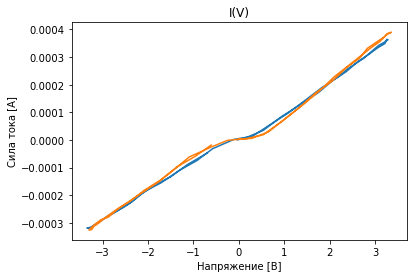

!!fail:  [76.4397852  26.58014418  8.95102925] -> [7.26339726 9.82541081] DR_DR_R detected like R_C
!!fail:  [49.74681905 33.82702378 21.82763028] -> [12.8043264  12.02479785] DR_DR_R detected like DR_DR
success: [60.98747629 82.80153576 68.98997137] -> [64.3516401  83.62852976 70.4015195 ] circuit DR_DR_R
success: [12.23210597 96.50237108 33.2972661 ] -> [11.4949171  83.08825009 40.27405699] circuit DR_DR_R
success: [39.3876806   9.43182556 15.78430625] -> [37.24122012  8.73211019 16.56333548] circuit DR_DR_R
!!fail:  [37.30951485  0.88342004 29.12693922] -> [14.58124348  0.91641355] DR_DR_R detected like DR_DR
success: [43.38686875 13.35228375  5.95127541] -> [47.34078287 13.44116529  6.15252405] circuit DR_DR_R
!!fail:  [78.10911672 34.5302998  21.45350577] -> [14.38219914 11.42184323] DR_DR_R detected like DR_DR
success: [23.58659235 88.71806502 98.71212738] -> [22.7724655  90.34009267 89.5980788 ] circuit DR_DR_R
success: [15.10803814 75.65809623 61.10333833] -> [15.38896084 81.47

In [11]:
class CircuitPredictor():
    """ class for circuit prediction from i,v curves using list of various circuit models"""
    def __init__(self):
        # append all availible circuit models to this list 
        self.circuitModels = []
        for cir in Circuit_Set:
            self.circuitModels.append(cir())
    
    
    def predict_from_model(self,analysis0):
        """"""
        m_List = []
        for m in self.circuitModels:
            Xvars = m.predict_from_model(analysis0)
            err = m.misfit(analysis0,Xvars)
            m_List.append((Xvars,m,err))
            
        m_List = sorted(m_List, key = lambda k:k[2])
        best = m_List[0] # best suited model
        return best
    
    def test_me(self):
        """"""
        self.test_rankN(1)
        self.test_rankN(2)
        self.test_rankN(3)
        
    def test_rankN(self,N,runsCount = 100,plot_Ok=10,plot_Fail=30):
        print('RANK'+str(N)+' CIRCUIT TESTING ..')
        CIR_N = []
        for cir in Circuit_Set:
            cN = cir()
            if cN.rank==N:
                CIR_N.append(cN)
                
        count_ok = 0
        count_fail = 0
        
        for _ in range(runsCount): 
            objCir = random.choice(CIR_N)
            
            x = 100*np.random.random(N)
            
            analysis0 = CreateCVC(objCir.build_circuit(x))
            Xvars, objX,_ = self.predict_from_model(analysis0)
            if isinstance(objX,type(objCir)):
                print('success: '+str(x)+' -> '+str(Xvars)+' circuit '+objX.title)
                count_ok += 1
                if plot_Ok>0:
                    plot_Ok -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars))
                    print('SUCCESS:')
                    plot_analysis_IV(analysis0)
                    plot_analysis_IV(analysis1)
                    plt.show()
            else:
                print('!!fail:  '+str(x)+' -> '+str(Xvars)+' '+objCir.title+' detected like '+objX.title)
                count_fail += 1
                if plot_Fail>0:
                    plot_Fail -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars))
                    print('FAIL:')
                    plot_analysis_IV(analysis0)
                    plot_analysis_IV(analysis1)
                    plt.show()
                
        print('\nSUCCESS: '+str(count_ok)+', FAIL: '+str(count_fail)+' of '+str(count_ok+count_fail)+' tests')
   
cre = CircuitPredictor()
cre.test_me()
